# 3rd Year Project - Alfred Backhouse
## Training creative cellular automata using GANs. 

# Set some initial parameters 

In [291]:
# Do we need to train the discriminator and generator?
# or just load the weights?
TRAIN_DISCRIMINATOR = False
TRAIN_GENERATOR = True
WGAN = False
TARGET_DIGIT = 8
iter_n = 100
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5
noise_factor = 0.001
lr_gen = 2e-5
lr_disc = 3e-6
SEED_STD = 100

# Imports and image / video utities 

In [292]:
import os
import PIL.Image, PIL.ImageDraw
import numpy as np
import matplotlib.pylab as pl
import glob
import imageio
import time
import random

import tensorflow as tf
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output()

# Load training data

In [293]:
import tensorflow as tf

# Load MNIST data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the images
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255

# Create a dataset for each digit
datasets = []
for digit in range(10):
    idx = train_labels == digit
    digit_images = train_images[idx]
    datasets.append(tf.data.Dataset.from_tensor_slices(digit_images).shuffle(1000).batch(60))


# Build the CA / generator model (with some utitilies for this)

In [294]:
#@title CA model and utils
def to_greyscale(x):
    y = tf.clip_by_value(x[..., 0:1], 0.0, 1.0)
    y = tf.squeeze(y, axis=-1) 
    return y

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, CHANNEL_N], np.float32)
    for i in range(h//2 - 1, h//2 + 1):
        for j in range(w//2-1, w//2 + 1):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
            seed[:, i, j, 1:] = np.random.normal(0, SEED_STD, size = seed[:, i, j, 1:].shape)
    return seed


def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    return noisy_images

class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.custom_init = CustomInitializer(mean=0) #was 0.008

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
            Conv2D(self.channel_n, 1, activation=tf.nn.tanh,
                kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    def reinitialize_weights(self):
        for layer in self.dmodel.layers:
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.assign(self.custom_init(layer.kernel.shape))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias.assign(self.custom_init(layer.bias.shape))

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return noisify(x, noise_factor) * tf.cast(life_mask, tf.float32)

build_generator().dmodel.summary()

Model: "sequential_745"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1117 (Conv2D)        (1, 3, 3, 80)             6480      
                                                                 
 conv2d_1118 (Conv2D)        (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# The kernel functions

In [295]:
def compute_kernel(x, y, sigma_list):
    """Computes a Gaussian kernel between two sets of samples using multiple bandwidth parameters."""
    beta_list = [1.0 / (2.0 * sigma**2) for sigma in sigma_list]
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.cast(tf.shape(x)[1], tf.float32)
    x_expanded = tf.expand_dims(x, 1)
    y_expanded = tf.expand_dims(y, 0)
    kernel_val = 0.
    for beta in beta_list:
        beta = tf.cast(beta, tf.float32)
        squared_diff = tf.reduce_sum(tf.square(x_expanded - y_expanded), 2)
        kernel_val += tf.exp(-beta * squared_diff)
    return kernel_val / tf.cast(tf.size(sigma_list), tf.float32)

def compute_mmd(x, y, sigma_list=[2, 5, 10, 20, 40, 80]):
    """Computes the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y."""
    x_kernel = compute_kernel(x, x, sigma_list)
    y_kernel = compute_kernel(y, y, sigma_list)
    xy_kernel = compute_kernel(x, y, sigma_list)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)


In [296]:
models = [build_generator() for _ in range(10)]


In [297]:
def generate_images(digit): 
    model = models[digit]
    x = make_seed(16)
    for i in range(iter_n):
        x = model(x, training=False) 
    
    generated_images = x

    fig, axes = plt.subplots(1, 16, figsize=(20, 2))
    greyscale_images = to_greyscale(generated_images)
    for i, ax in enumerate(axes):
        ax.imshow(greyscale_images[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Images for Digit {digit}')
    plt.show()

In [298]:
# # Generate and display images for each digit
# for i, model in enumerate(models):
#     generate_images(i)


Training model for digit 2


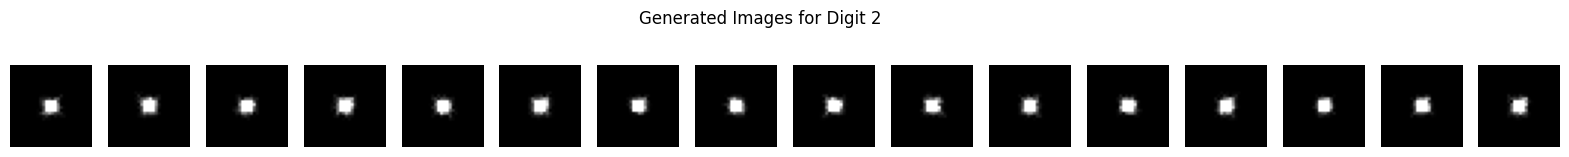

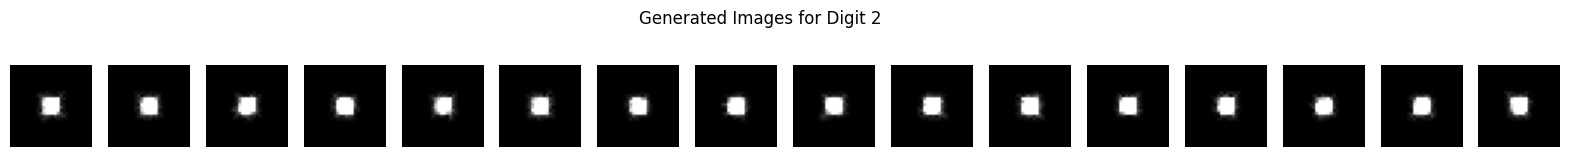

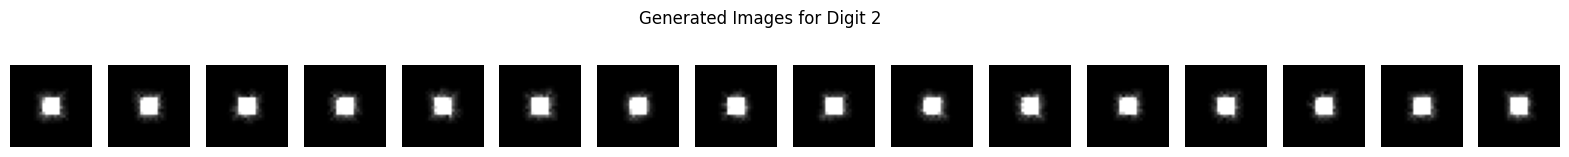

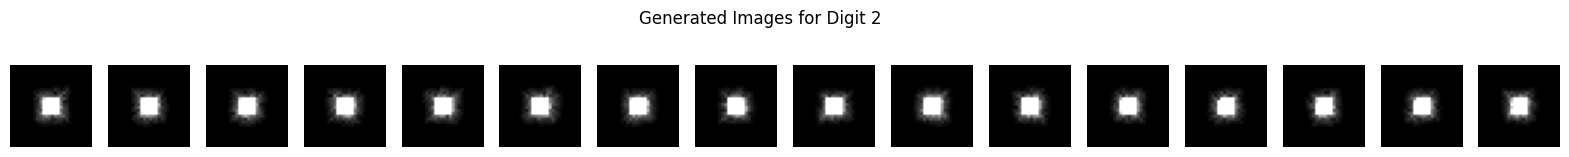

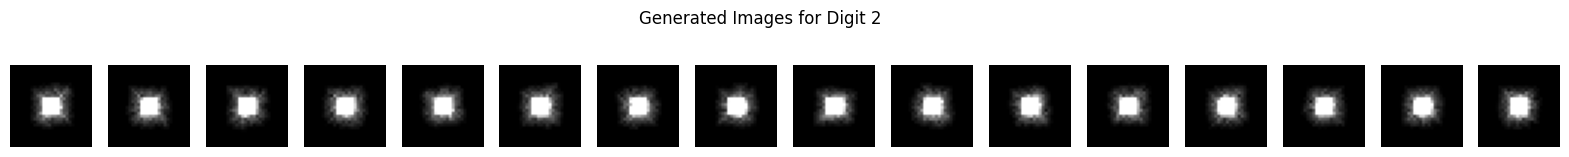

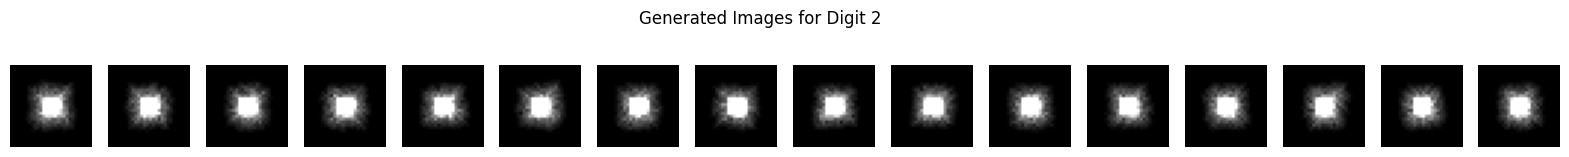

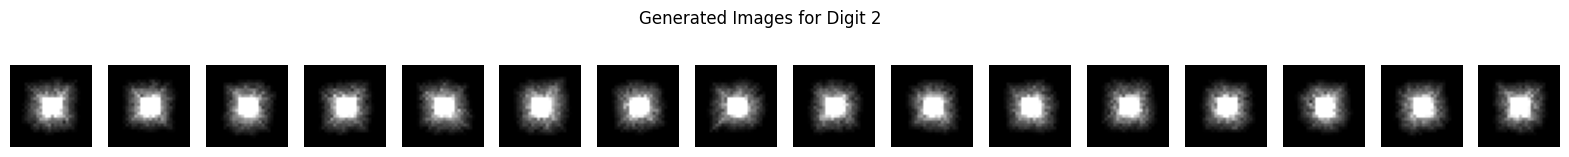

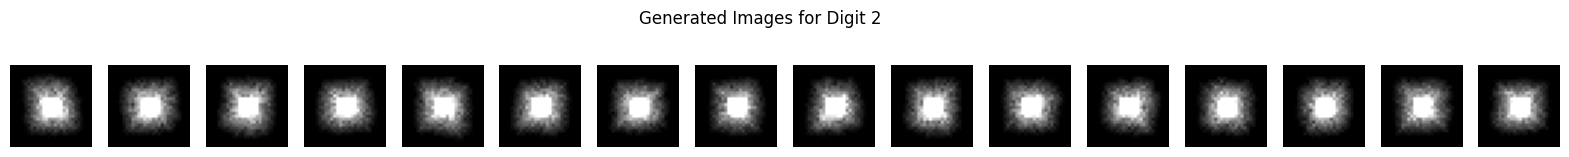

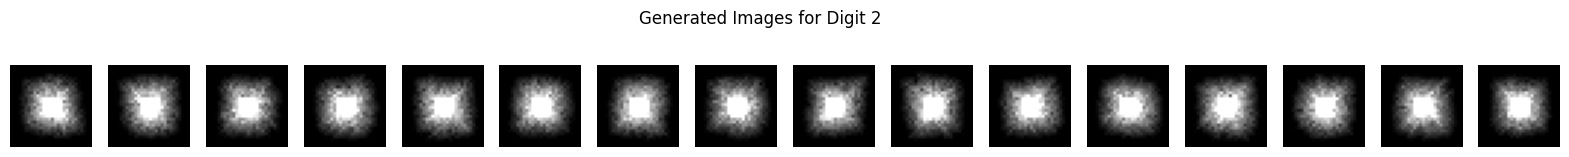

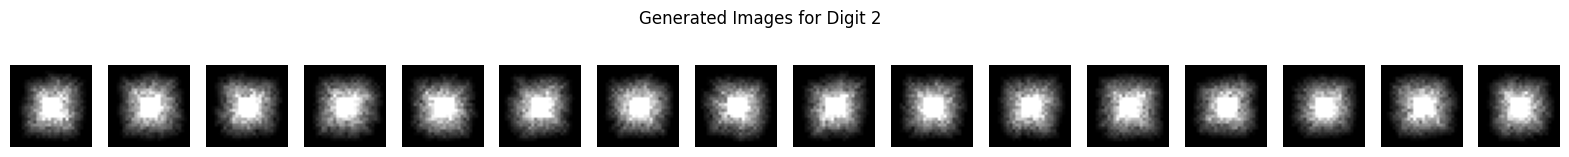

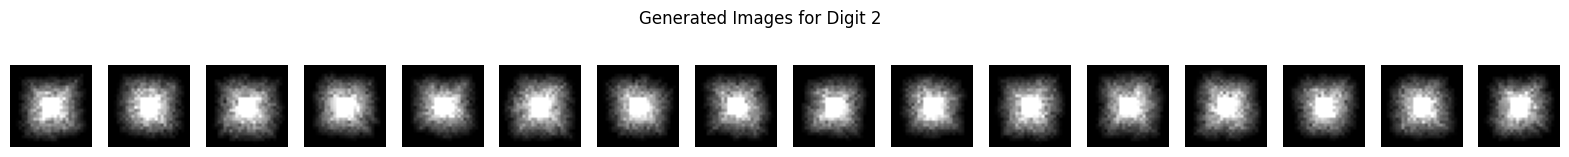

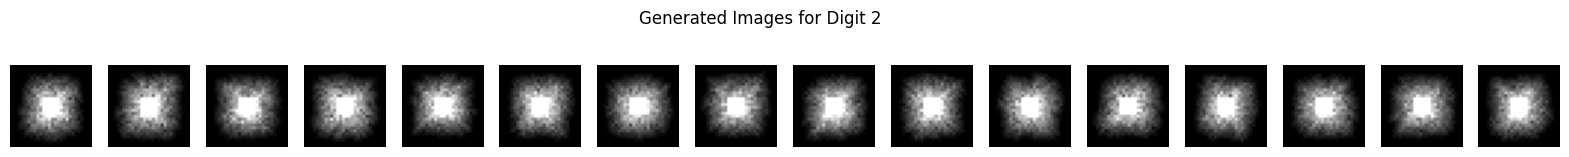

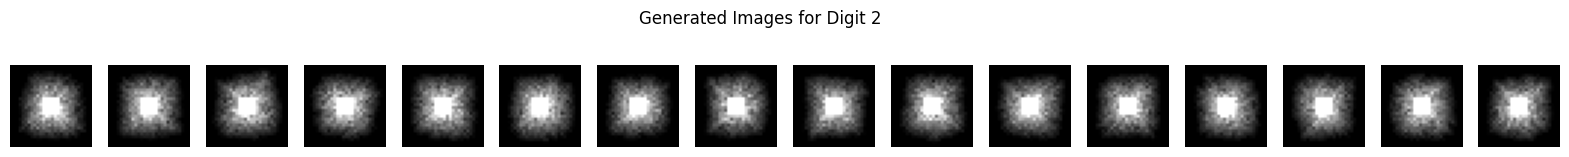

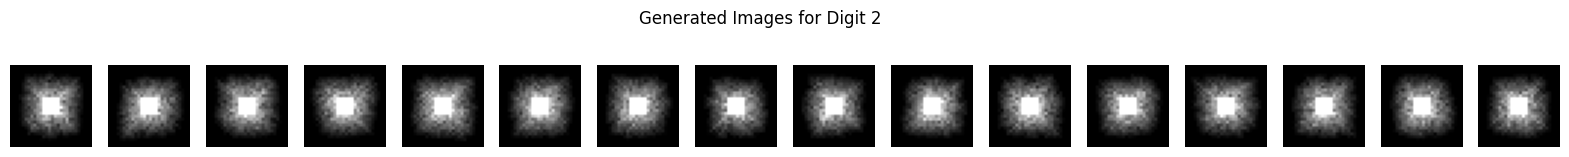

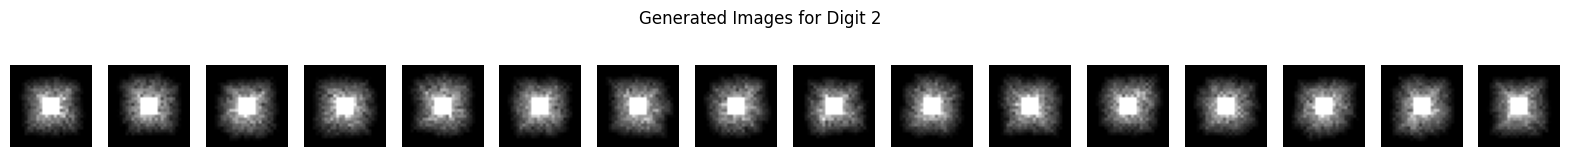

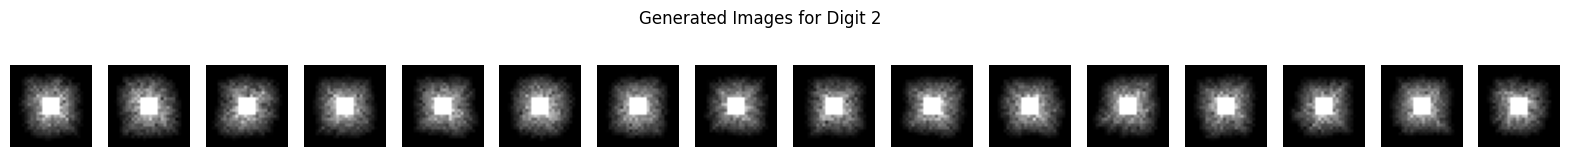

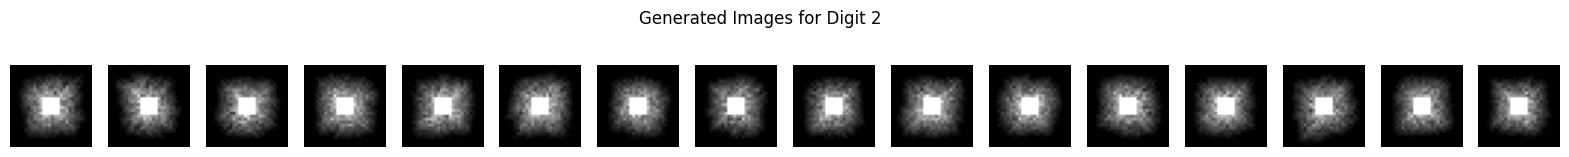

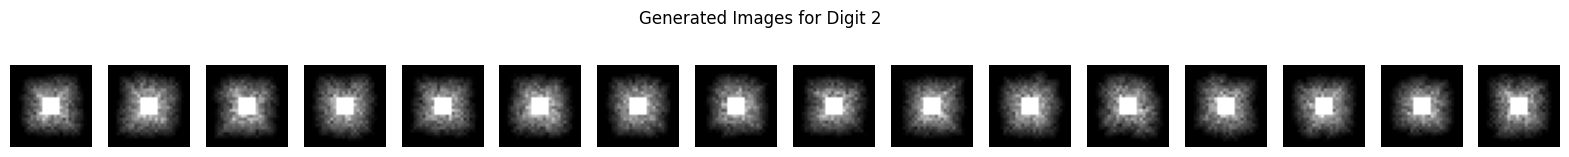

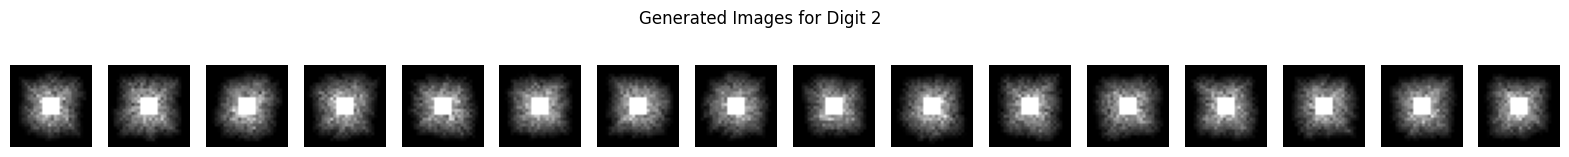

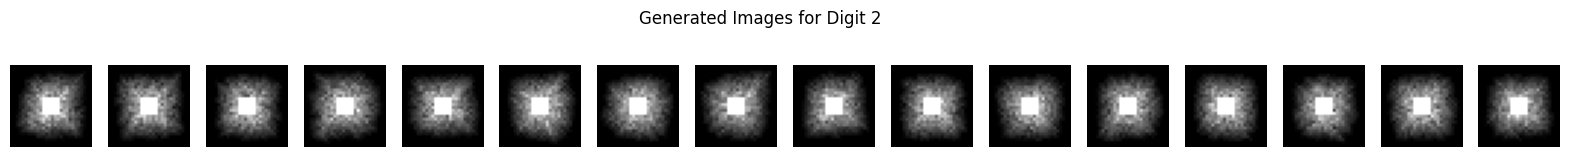

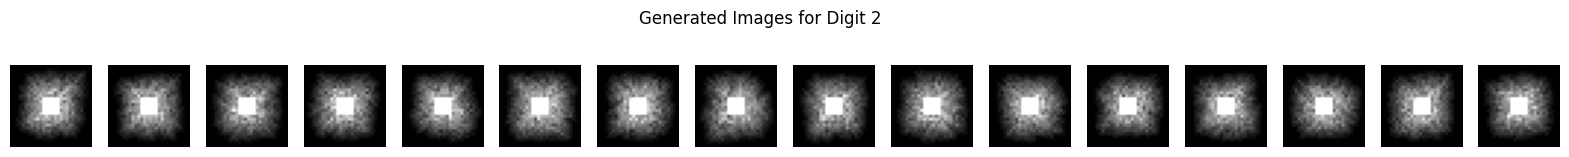

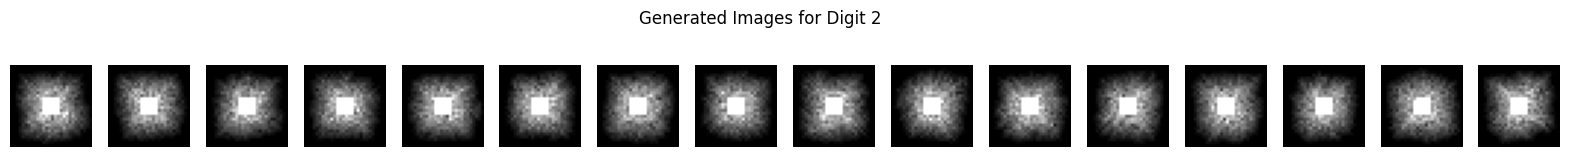

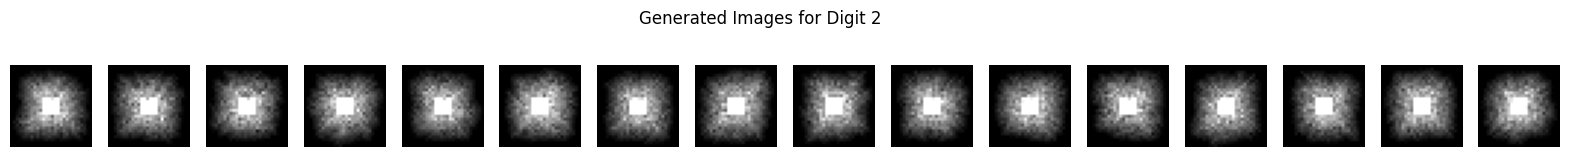

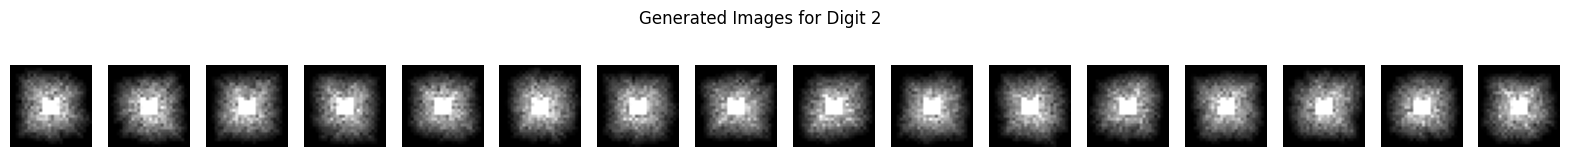

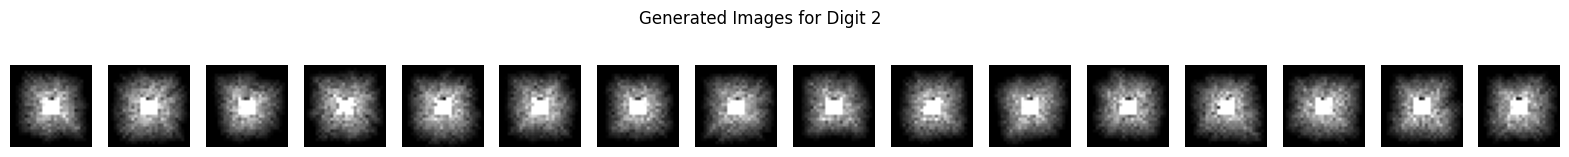

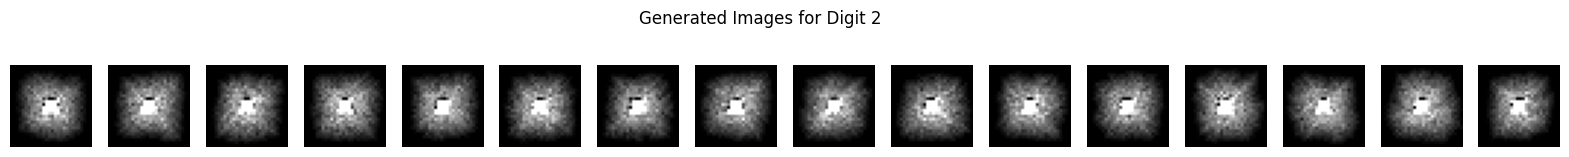

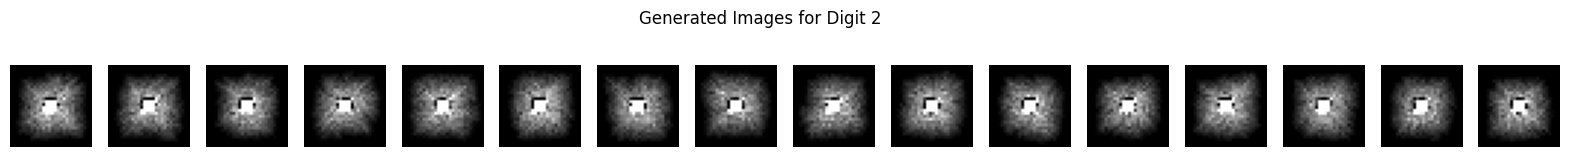

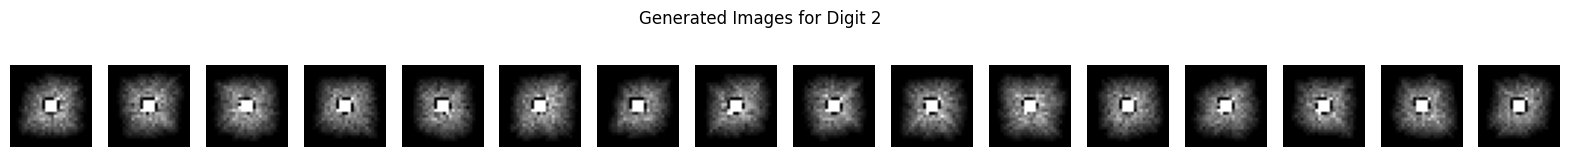

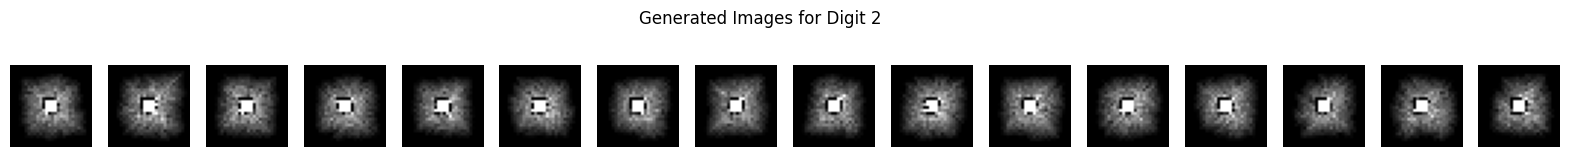

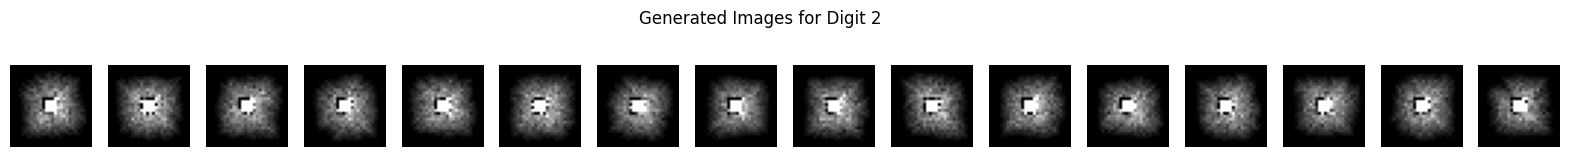

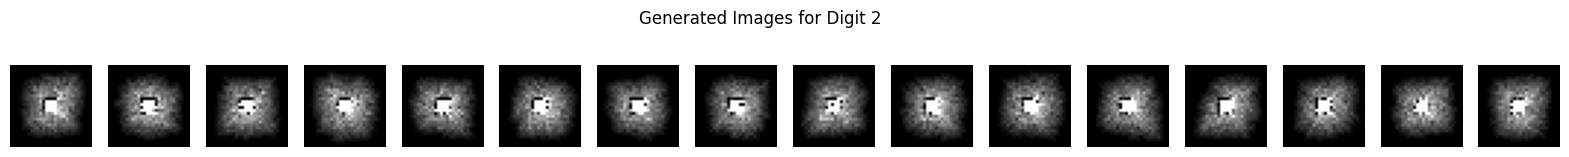

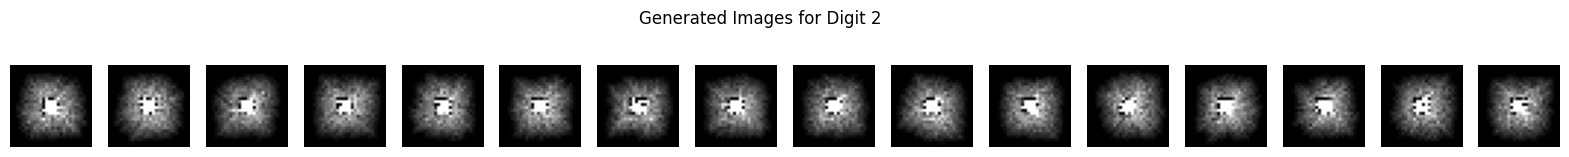

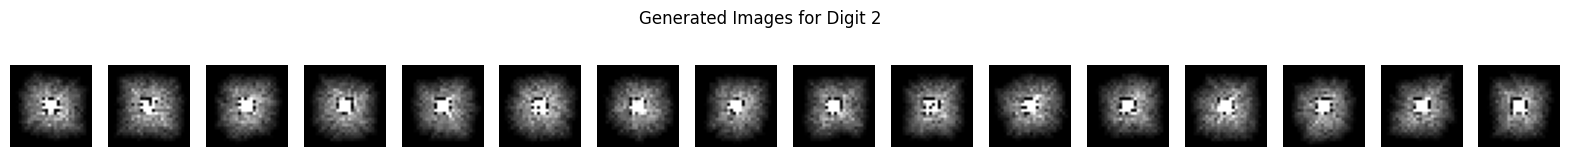

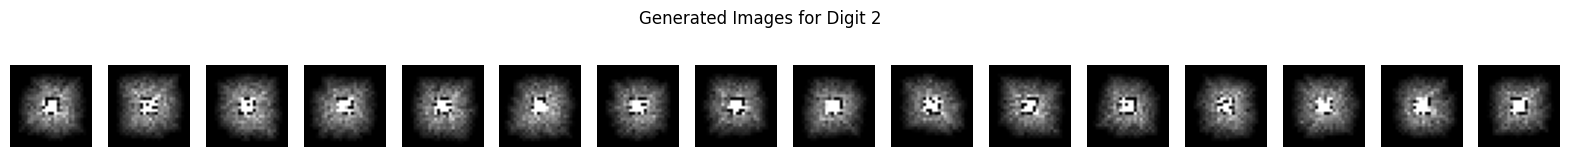

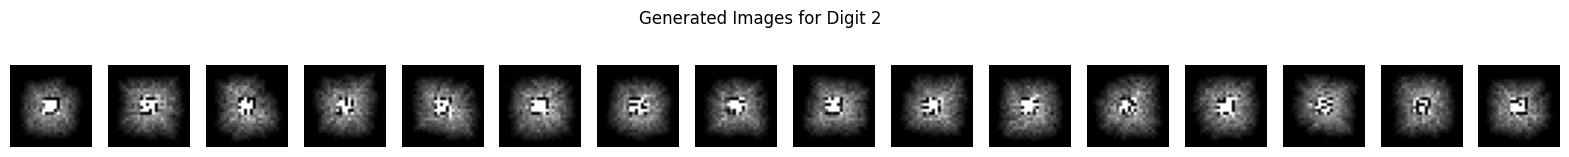

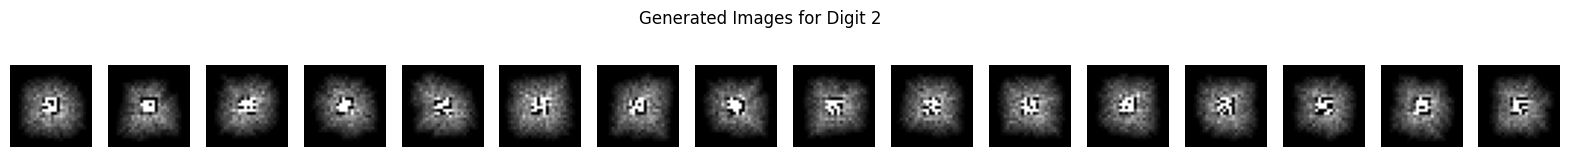

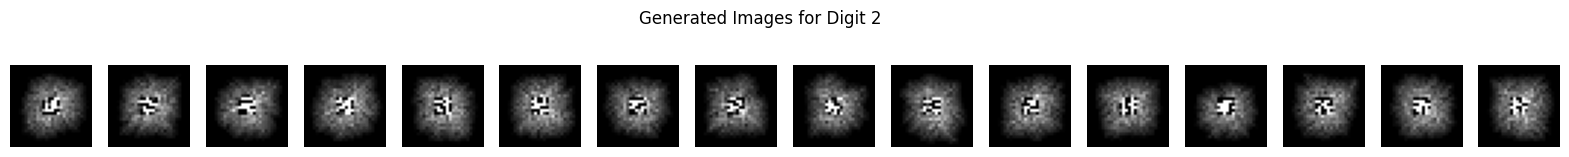

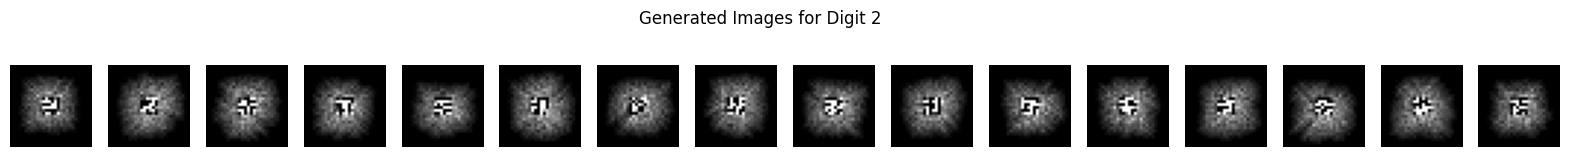

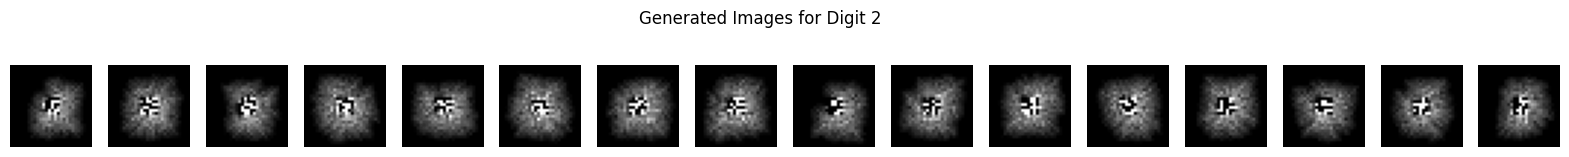

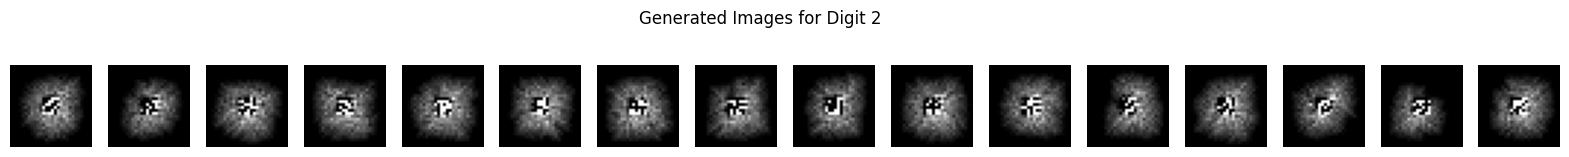

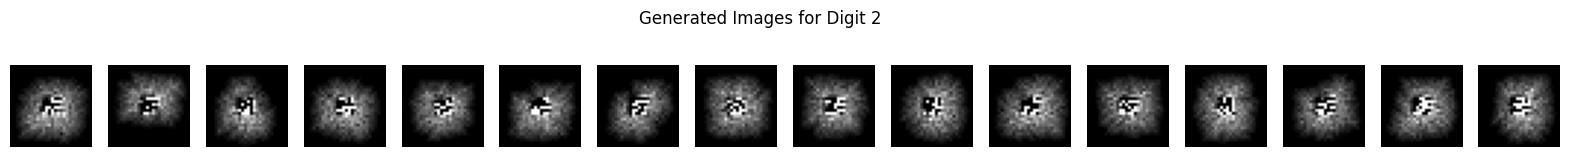

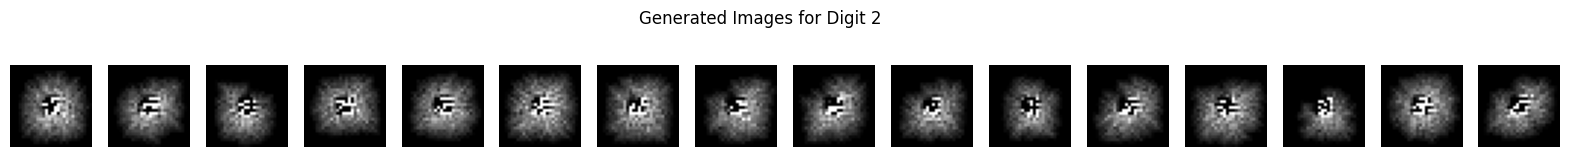

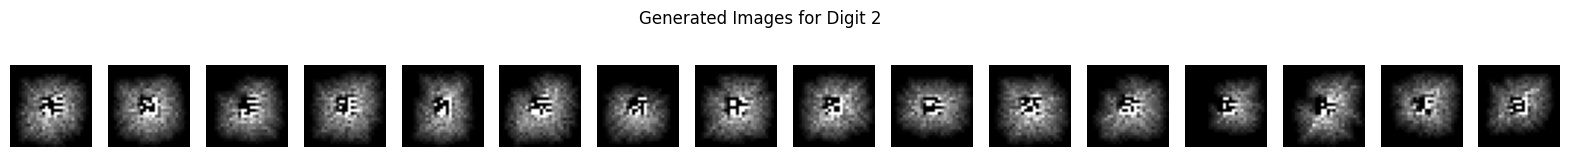

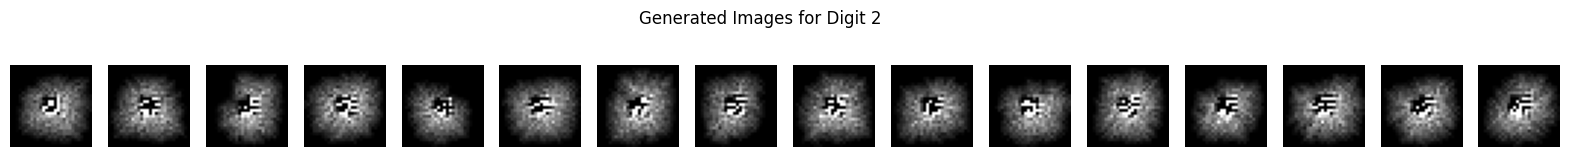

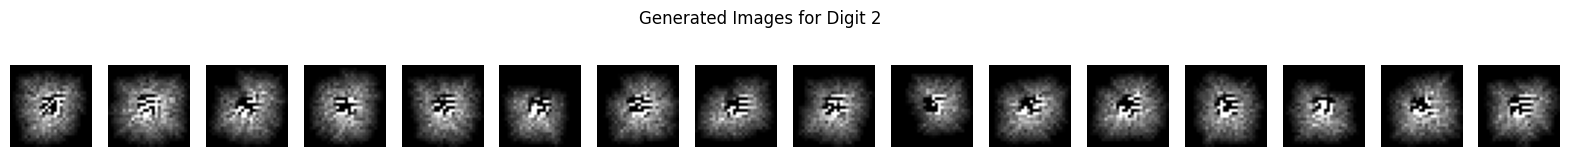

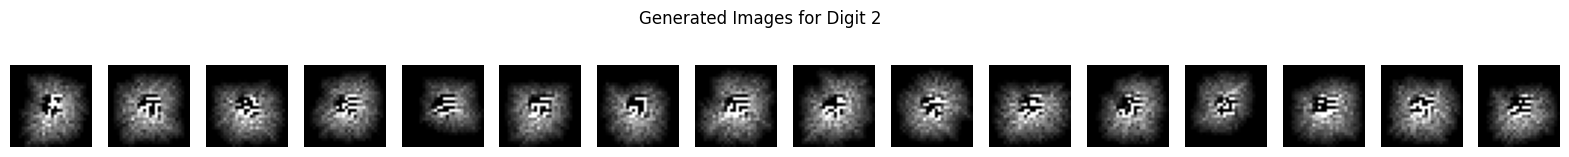

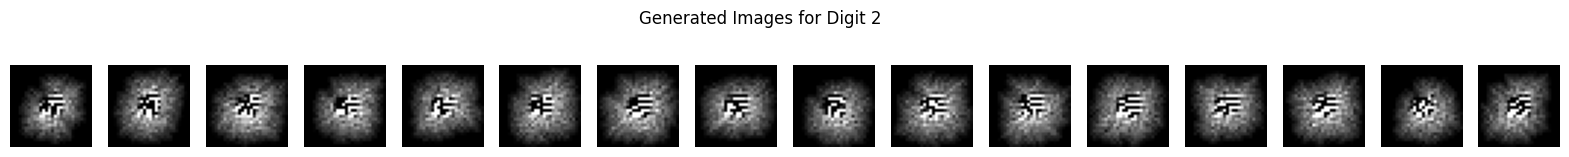

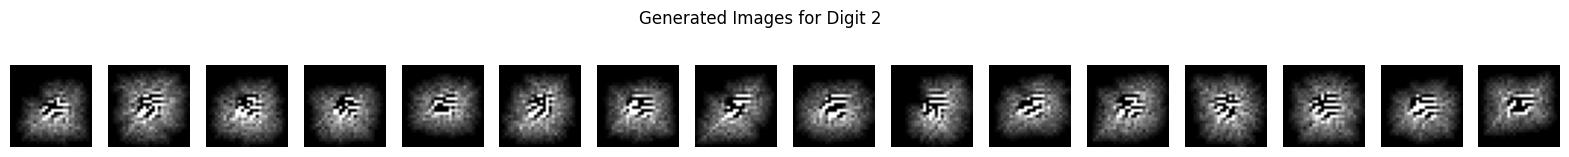

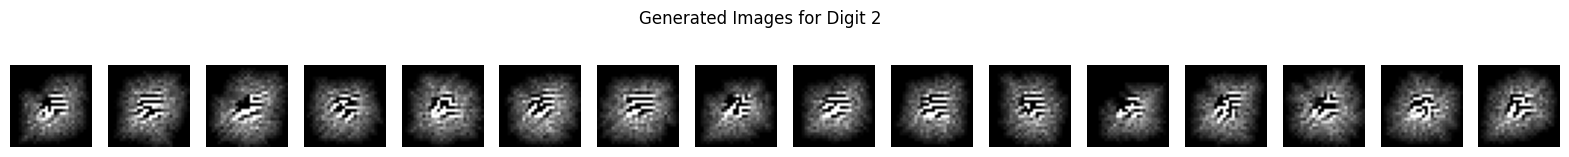

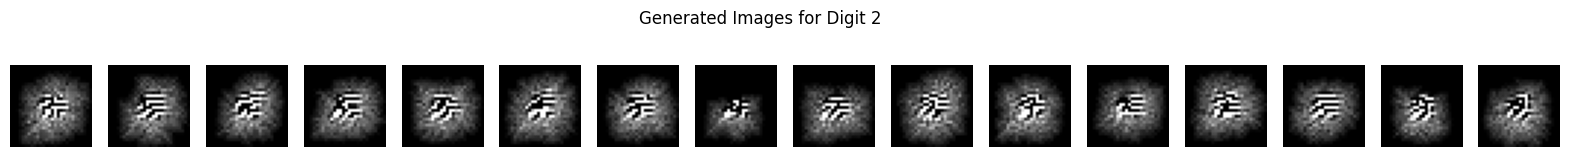

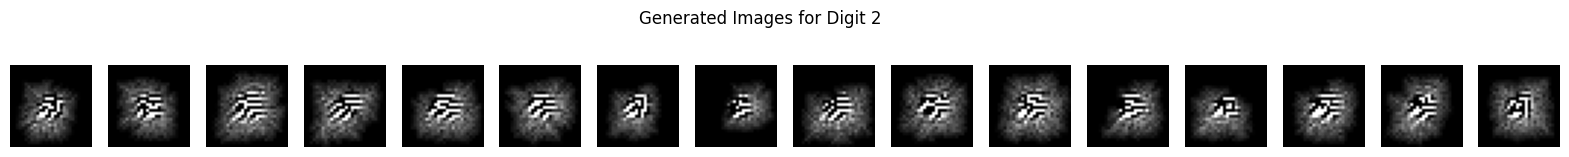

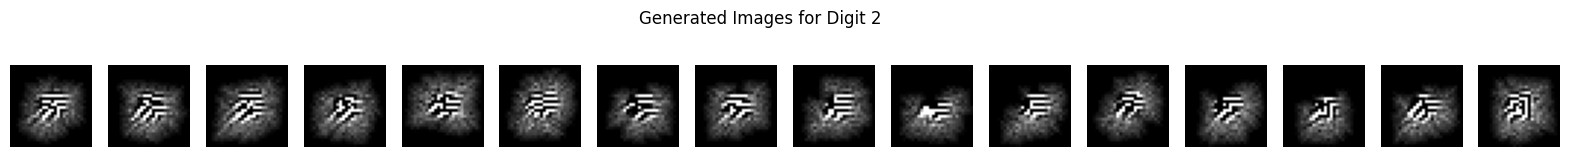

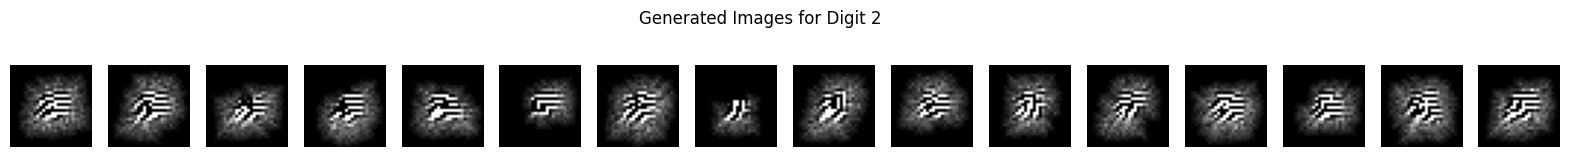

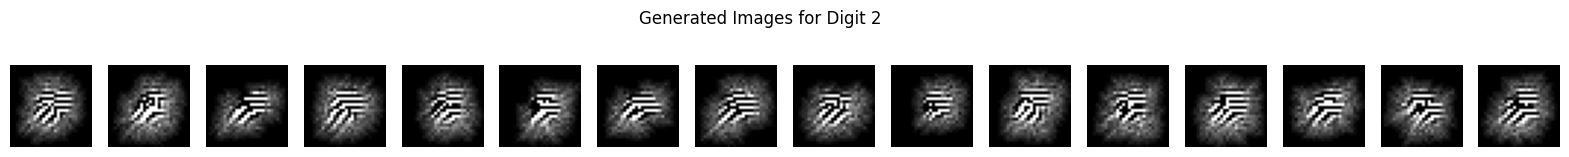

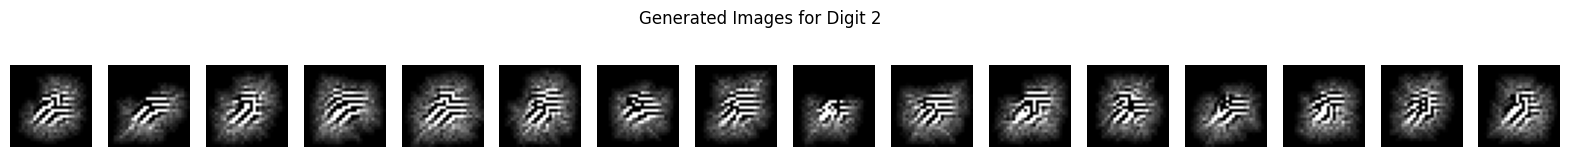

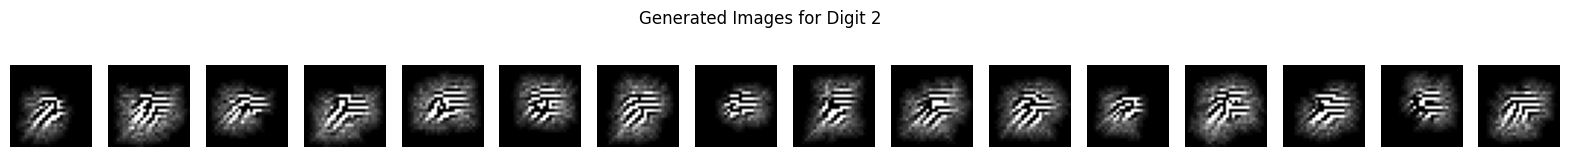

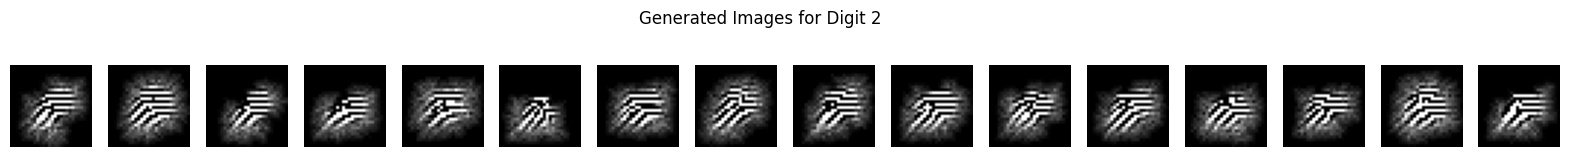

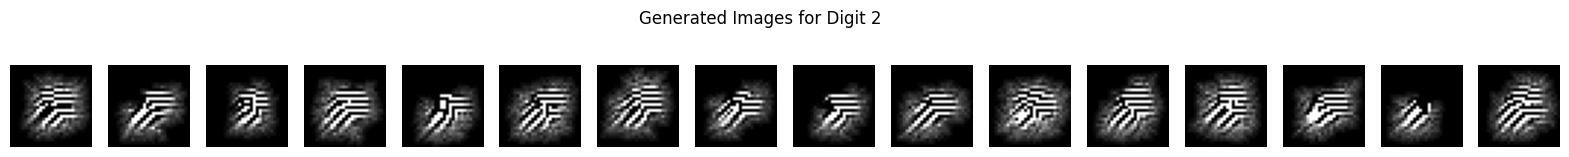

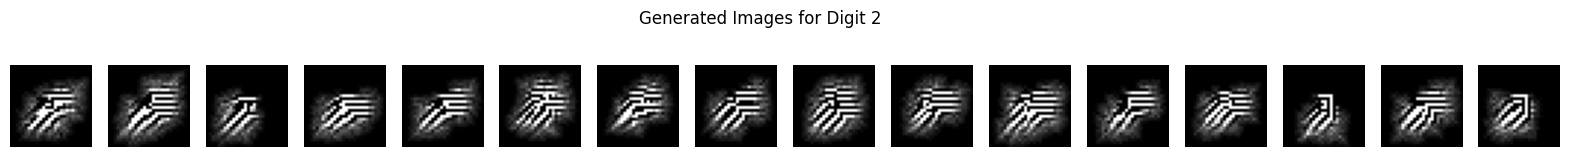

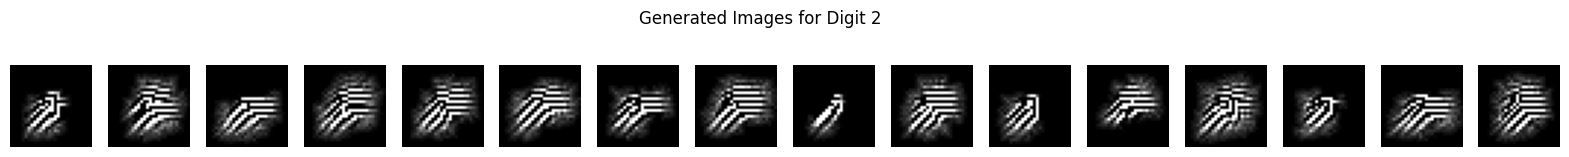

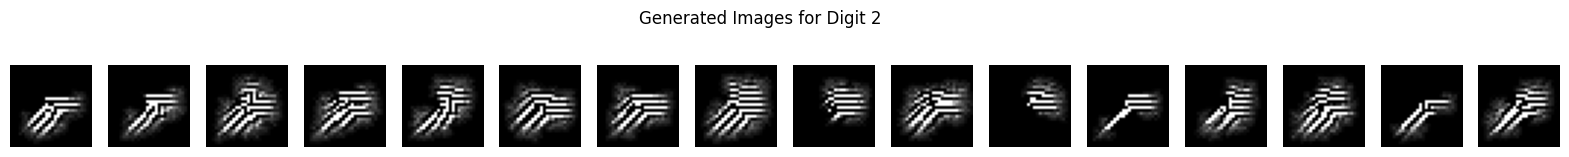

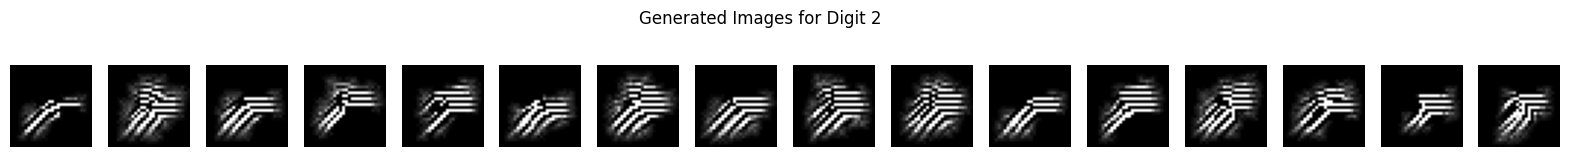

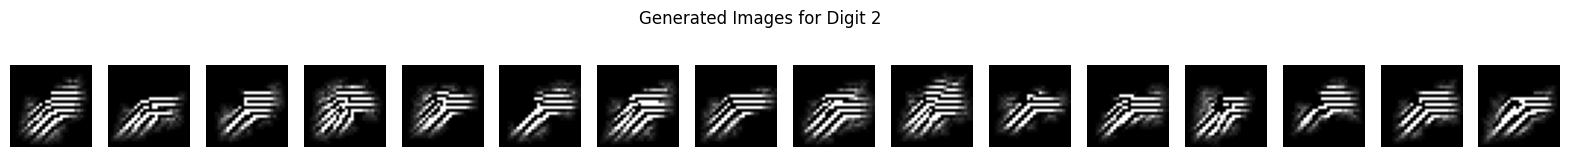

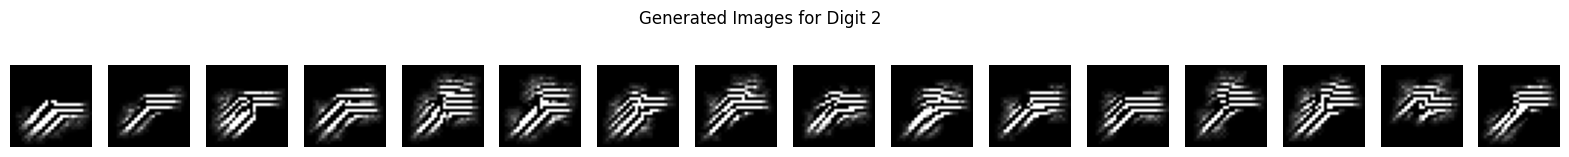

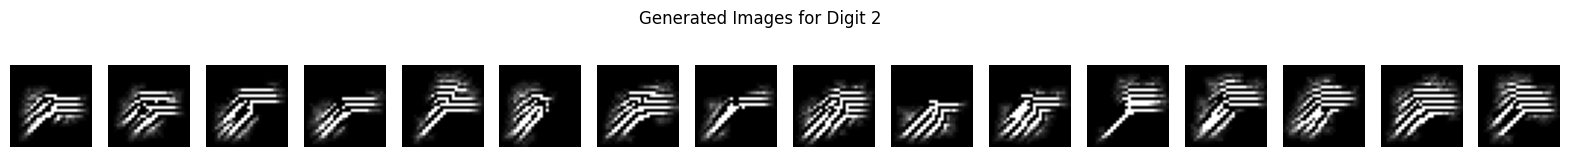

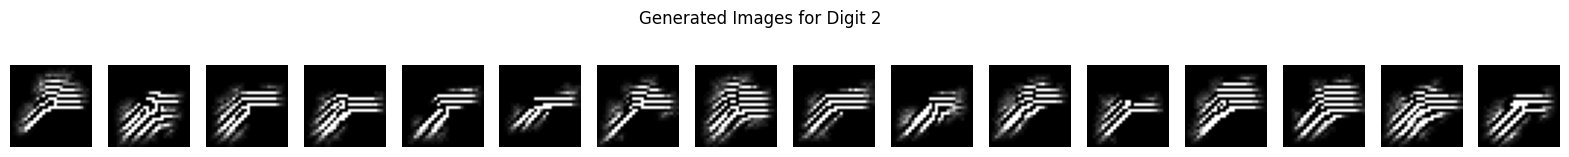

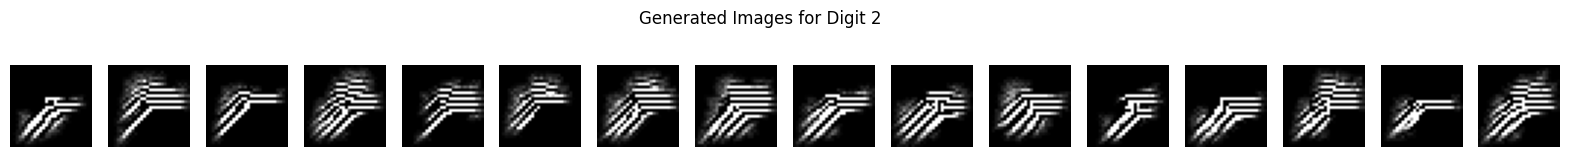

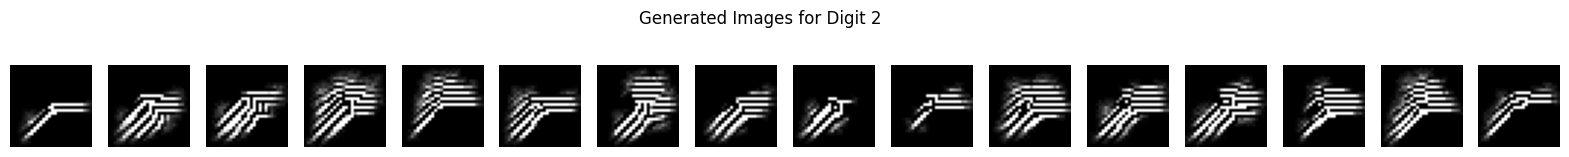

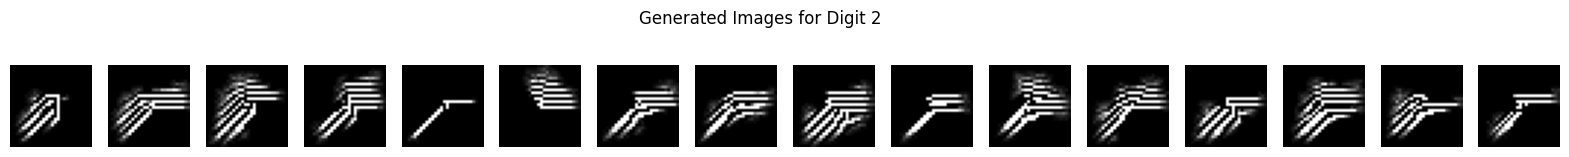

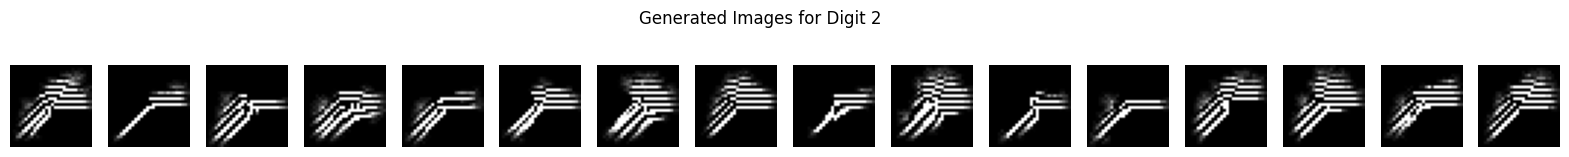

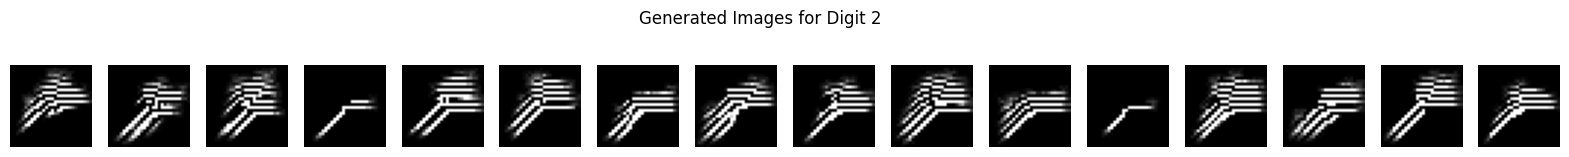

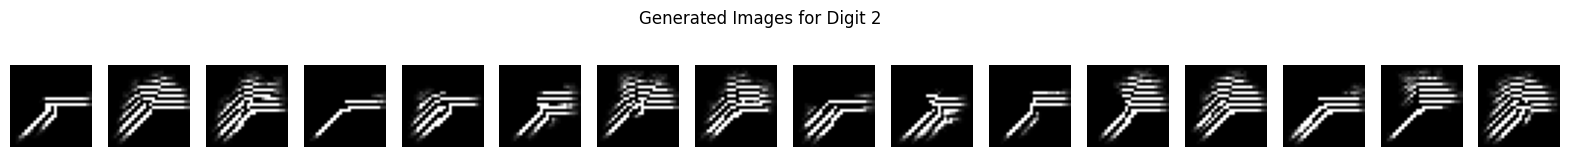

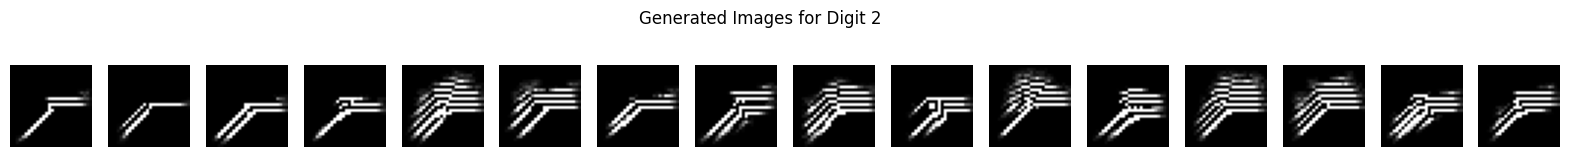

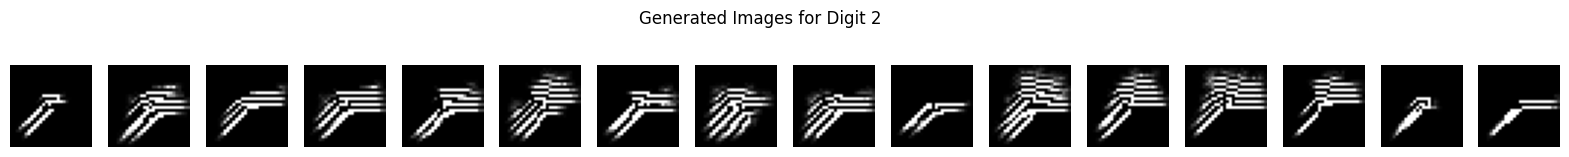

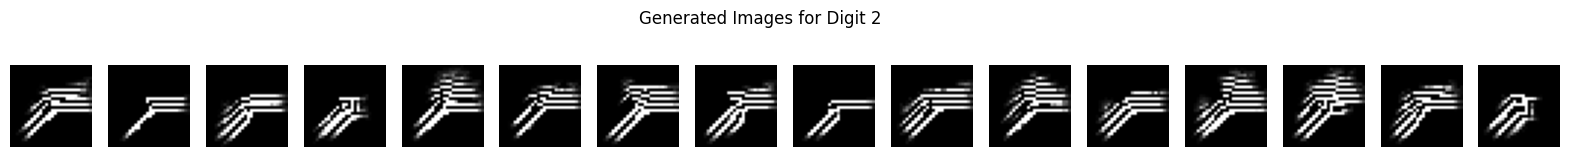

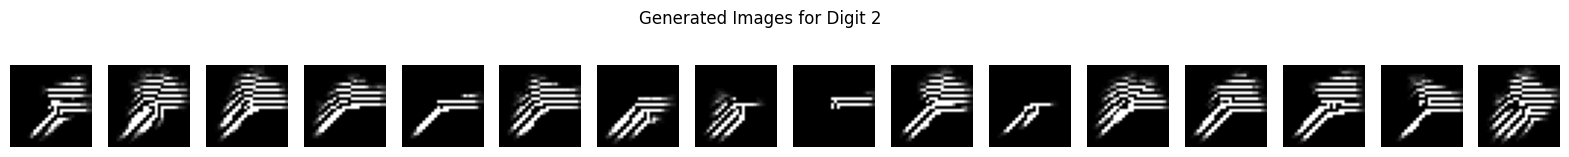

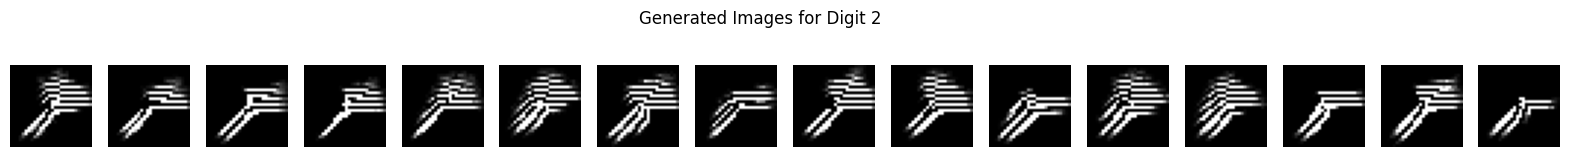

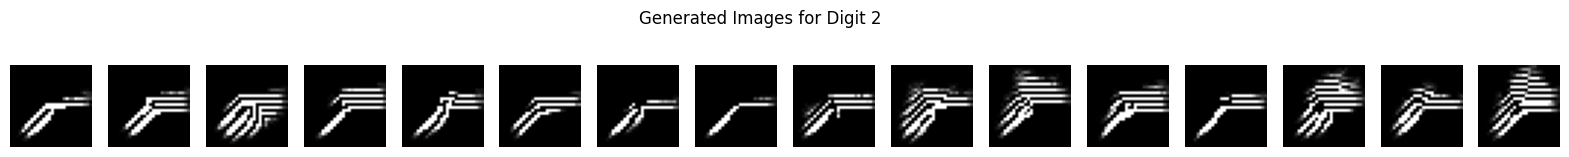

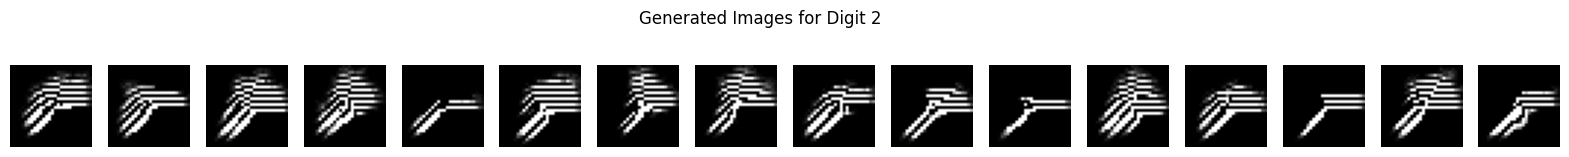

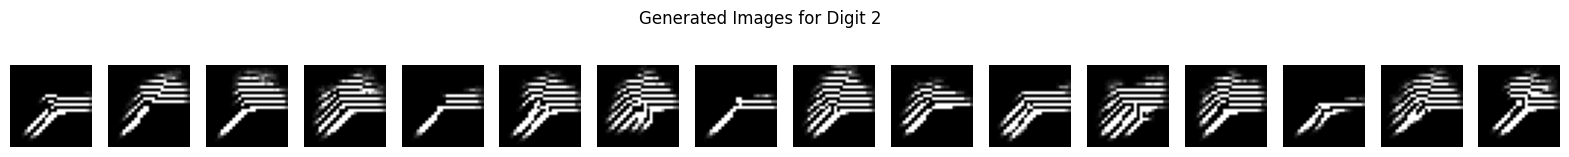

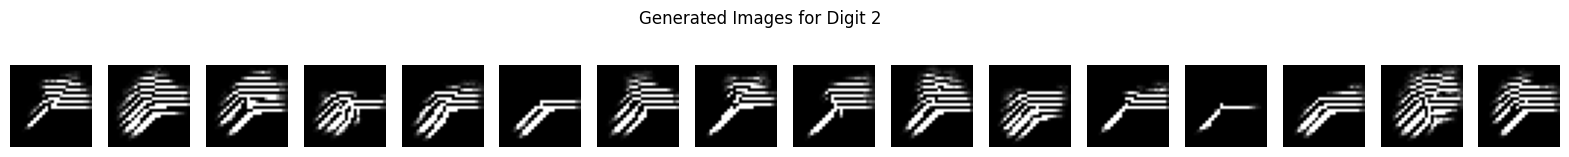

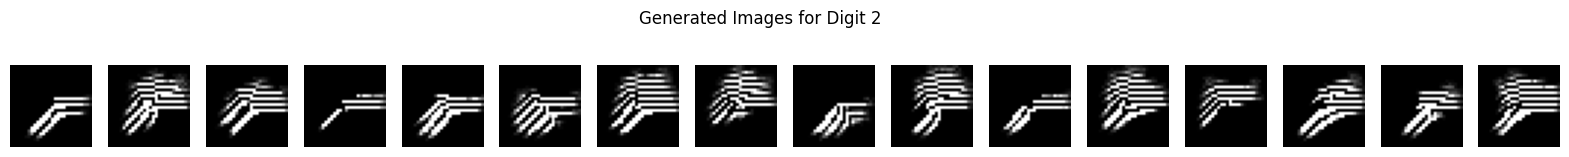

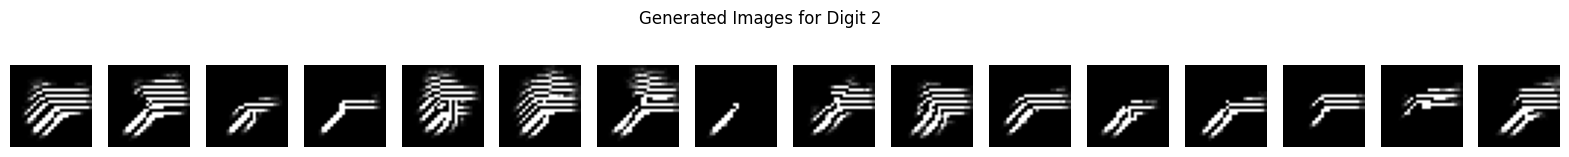

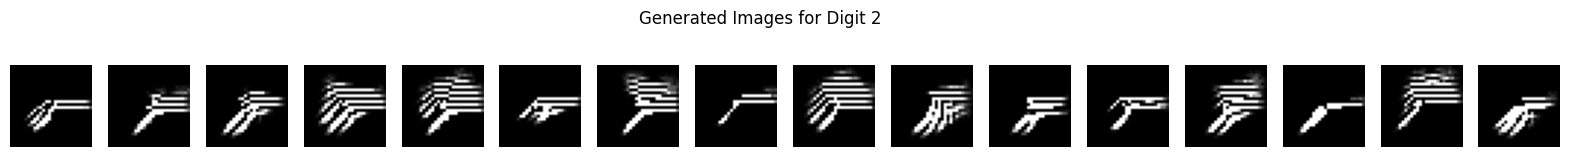

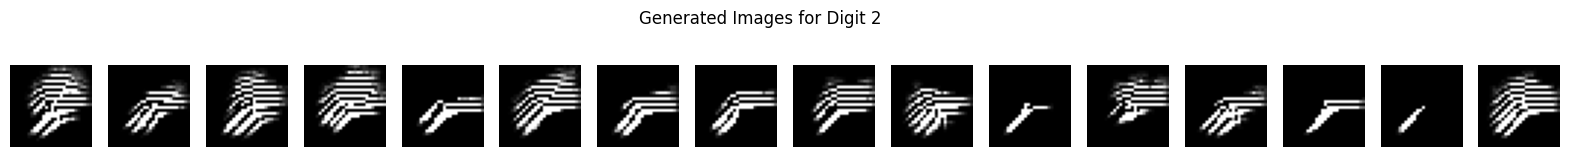

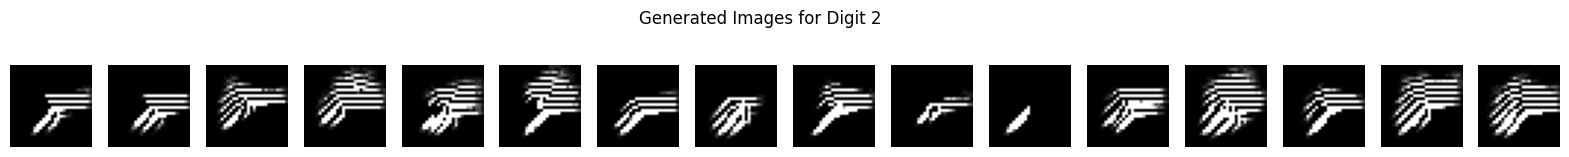

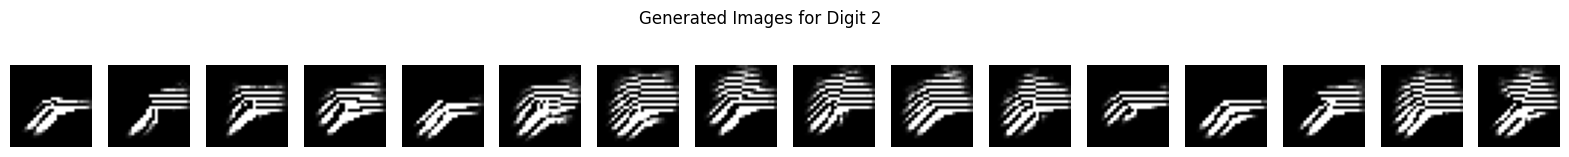

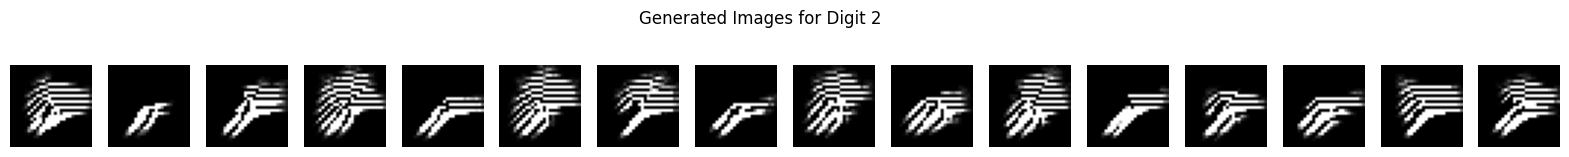

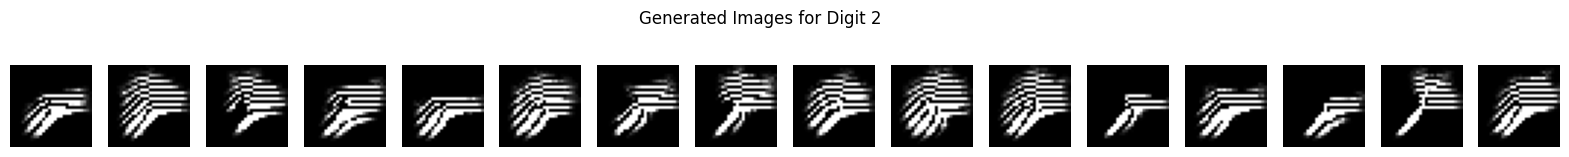

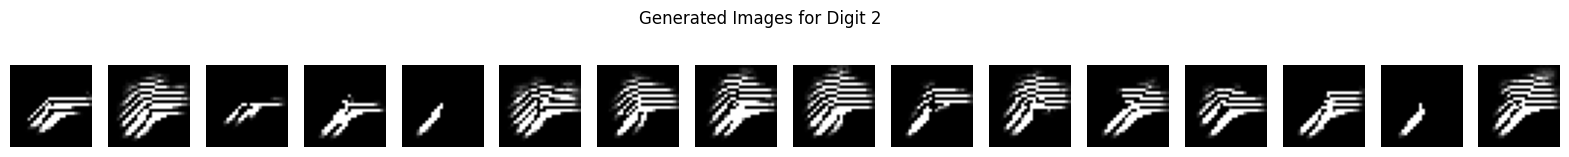

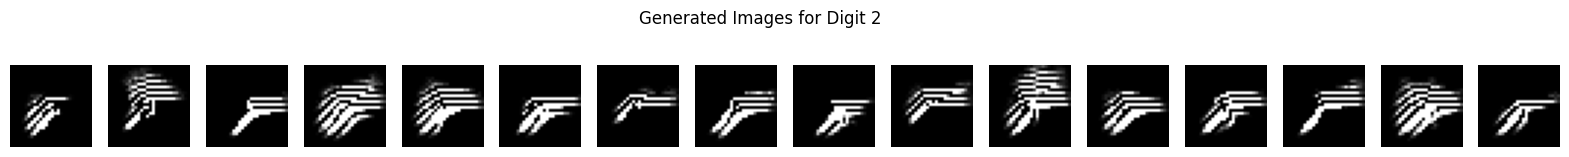

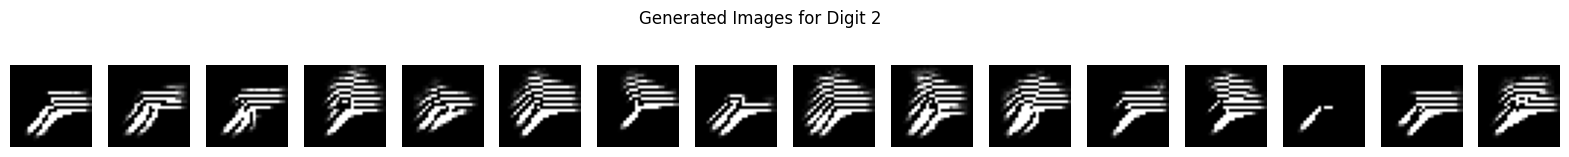

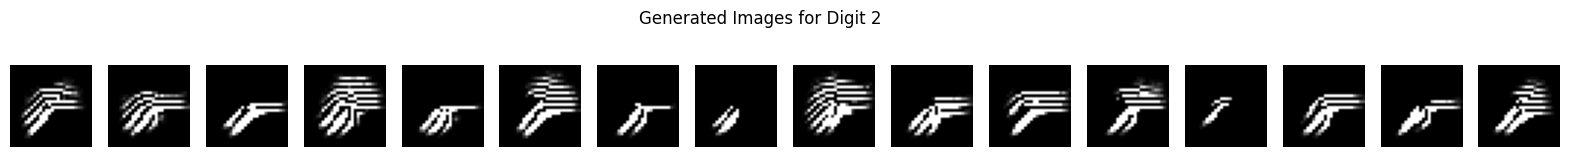

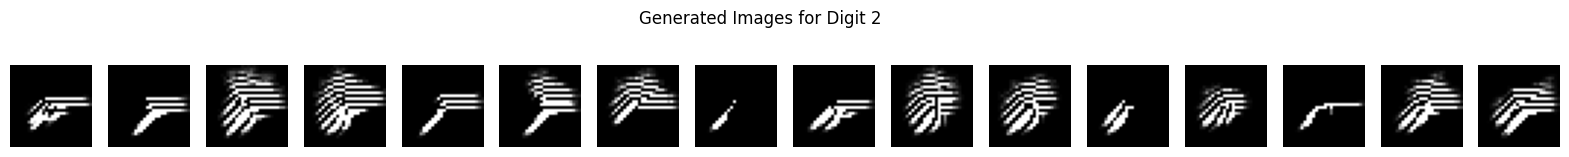

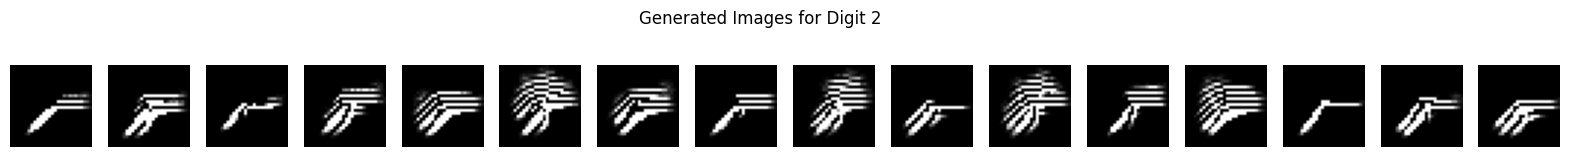

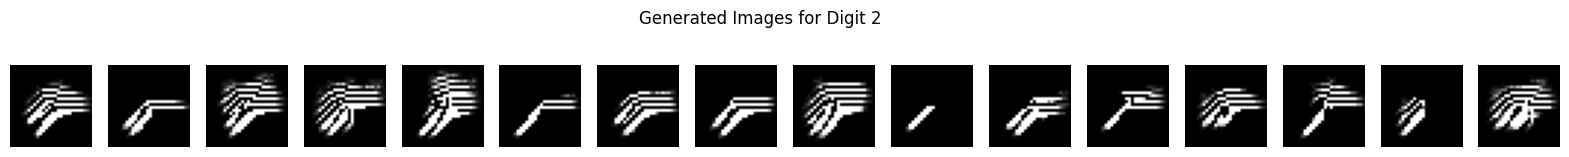

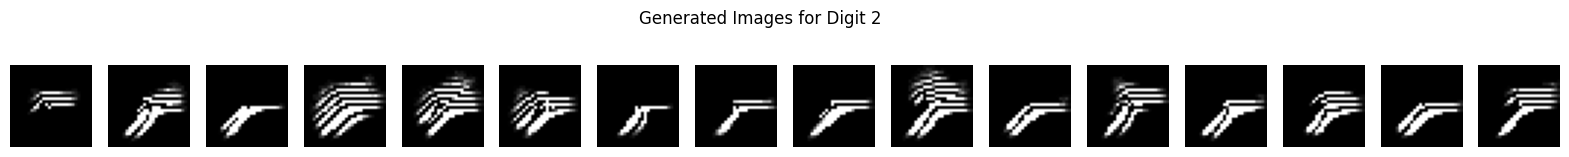

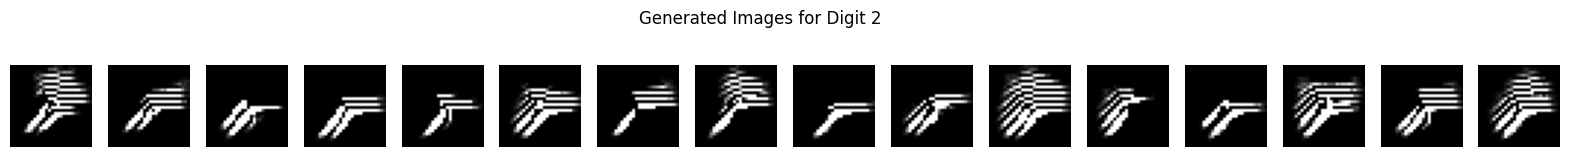

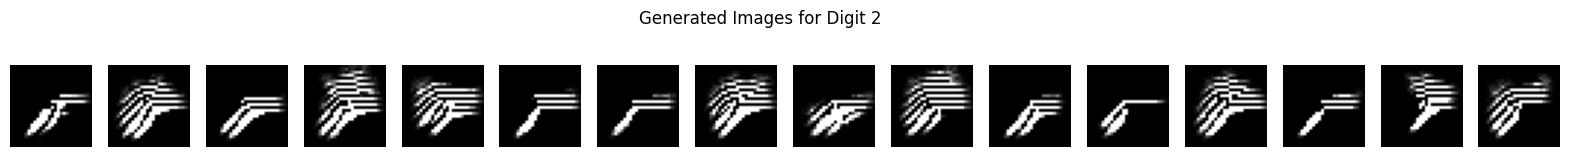

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 14112 values, but the requested shape has 47040 [Op:Reshape]

In [299]:
# Assume GMMN and compute_mmd are defined as before

def train_model_for_digit(digit_dataset, i):
    digit = i
    model = models[i]
    lr = 2e-4
    lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr, lr*0.1])
    optimizer = tf.keras.optimizers.legacy.Adam()

    epochs = 10  # You might adjust this based on experimentation
    for epoch in range(epochs):
        for real_images in digit_dataset:
            x = make_seed(real_images.shape[0])
            with tf.GradientTape() as tape:
                for i in tf.range(iter_n): 
                    x = model(x, training=True)
                generated_images = to_greyscale(x)
                generated_images = tf.reshape(generated_images, [60, 28*28])
                mmd_loss = compute_mmd(real_images, generated_images)
            
            gradients = tape.gradient(mmd_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            generate_images(digit)
        print(f'Epoch {epoch+1}, MMD Loss: {mmd_loss.numpy()}')
        
    return model

for i, dataset in enumerate(datasets):
    if i == 0 or i == 1: 
        continue
    print(f"Training model for digit {i}")
    model = train_model_for_digit(dataset, i)


In [300]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))
    images = to_greyscale(images)
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [301]:
def generate_and_save_images(model):
    
    x = make_seed(16)

    for i in tf.range(iter_n):
        x = model(x, training=False)
    print_image_sample(x)

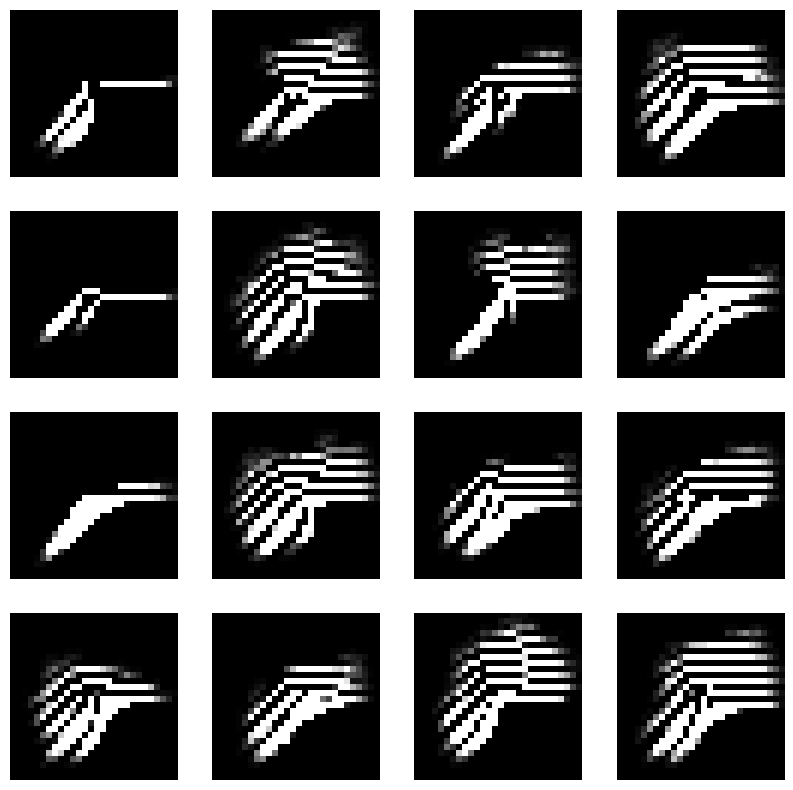

In [302]:
generate_and_save_images(models[2])